In [ ]:
# https://nthu-datalab.github.io/ml/labs/12-1_CNN/12-1_CNN.html

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import IPython.display as display
import matplotlib.pyplot as plt
import pathlib
import random
import numpy as np
import re
import os
from skimage import io
from PIL import Image
# cell = tf.contrib.rnn.BasicLSTMCel
# tfe = tf.contrib.eager
# tf.enable_eager_execution()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!nvidia-smi

Tue Nov  9 16:28:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [17]:
# You need to download the prepared data and unzip the file in current path('./')
data_root = pathlib.Path('./drive/MyDrive/Colab Notebooks/oregon_wildlife/oregon_wildlife')

# print the subfolders.
print('classes:')
for item in data_root.iterdir():
    print(item)
    
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths = shuffle(all_image_paths, random_state=1)
all_image_paths = [path for path in all_image_paths if path[-3:] not in ('gif','bmp')]
image_count = len(all_image_paths)
print('\ntotal img num:', image_count)

classes:
drive/MyDrive/Colab Notebooks/oregon_wildlife/oregon_wildlife/nutria
drive/MyDrive/Colab Notebooks/oregon_wildlife/oregon_wildlife/cougar
drive/MyDrive/Colab Notebooks/oregon_wildlife/oregon_wildlife/raven
drive/MyDrive/Colab Notebooks/oregon_wildlife/oregon_wildlife/bald_eagle
drive/MyDrive/Colab Notebooks/oregon_wildlife/oregon_wildlife/deer
drive/MyDrive/Colab Notebooks/oregon_wildlife/oregon_wildlife/virginia_opossum
drive/MyDrive/Colab Notebooks/oregon_wildlife/oregon_wildlife/black_bear
drive/MyDrive/Colab Notebooks/oregon_wildlife/oregon_wildlife/raccoon
drive/MyDrive/Colab Notebooks/oregon_wildlife/oregon_wildlife/sea_lions
drive/MyDrive/Colab Notebooks/oregon_wildlife/oregon_wildlife/red_fox

total img num: 7167


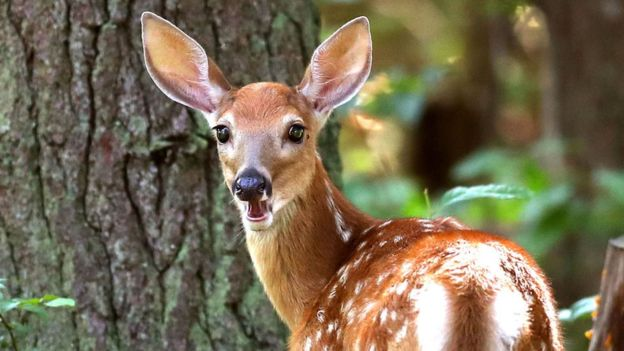

deer


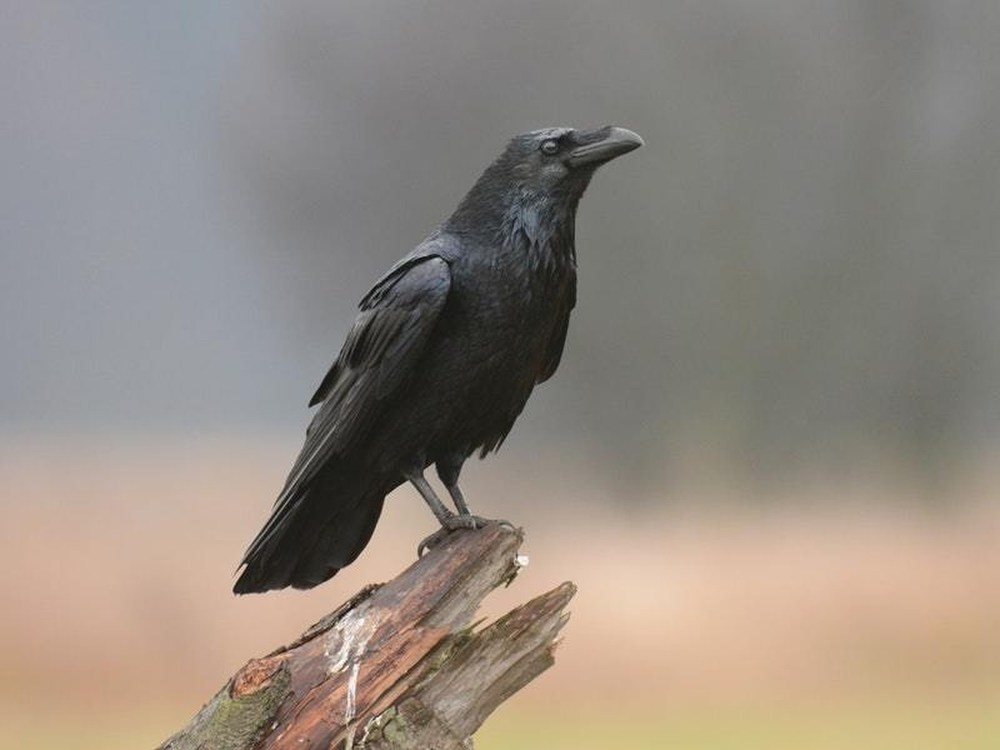

raven


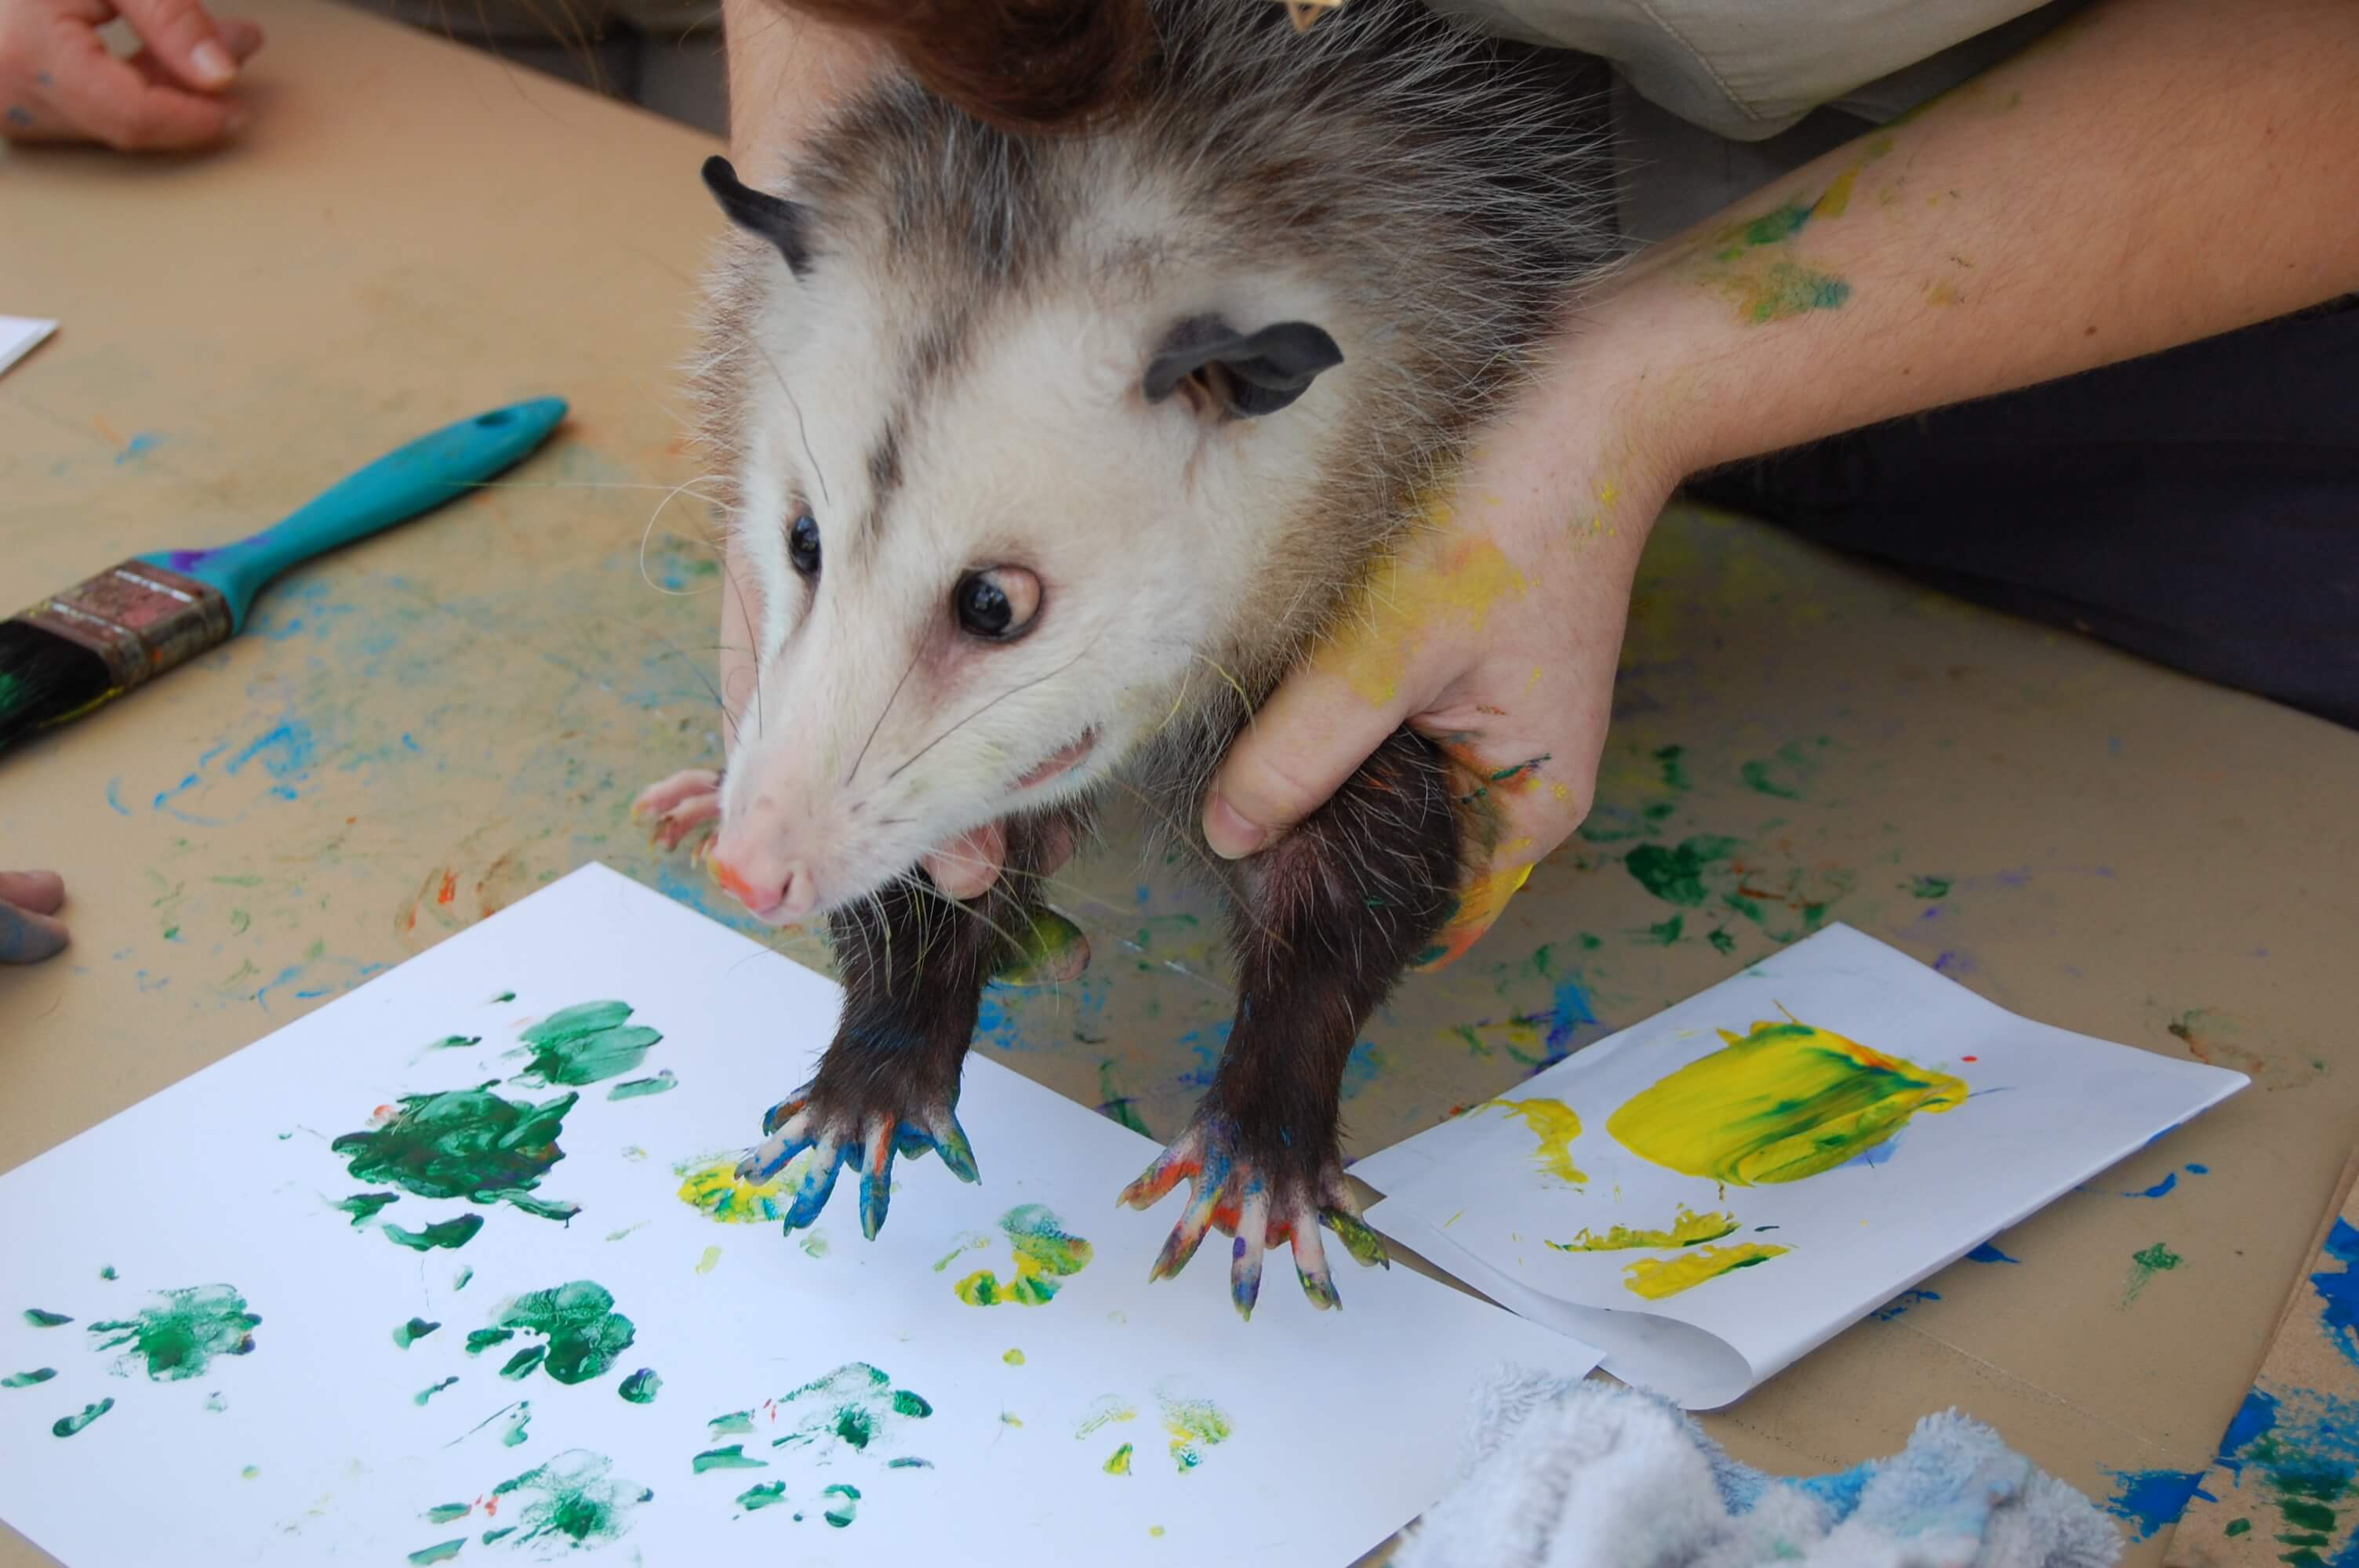

virginia_opossum


In [18]:
# random showing 3 iamges for you
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path, width=200, height=200))
    print(image_path.split('/')[-2])

In [19]:
# get the labels
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
# total labels
n_classes = len(label_names)
print(label_names)

['bald_eagle', 'black_bear', 'cougar', 'deer', 'nutria', 'raccoon', 'raven', 'red_fox', 'sea_lions', 'virginia_opossum']


In [ ]:
# get the mapping dict
label_to_index = dict((name, index) for index,name in enumerate(label_names))
index_to_label = dict((index, name) for index,name in enumerate(label_names))
print(label_to_index)

{'bald_eagle': 0, 'black_bear': 1, 'cougar': 2, 'deer': 3, 'nutria': 4, 'raccoon': 5, 'raven': 6, 'red_fox': 7, 'sea_lions': 8, 'virginia_opossum': 9}


In [ ]:
# get the label data
all_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]
print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [8, 9, 6, 9, 2, 6, 2, 4, 2, 4]


In [ ]:
# Create training and validation sets using an 80-20 split
img_path_train, img_path_val, label_train, label_val = train_test_split(all_image_paths,
                                all_image_labels,test_size=0.2,random_state=0)
print('training data: %d'%(len(img_path_train)))
print('testing data: %d'%(len(img_path_val)))

training data: 5733
testing data: 1434


In [7]:
# You will use these setting in your code, pls do not modify these 4.
IMAGE_SIZE_CROPPED = 224
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300
IMAGE_DEPTH = 3


# feel free to modify these Settings.
BUFFER_SIZE = 10000
BATCH_SIZE = 32

In [ ]:
# The following functions can be used to convert a value to a type compatible with tf.Example.

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

# **Read image and cast it to string type , and feed to features as bytes string**

In [ ]:
def serialize_example(image_string, label):
    """
    Creates a tf.Example message ready to be written to a file.
    """
    img = tf.io.read_file(image_string)
    img = tf.cast(img, tf.string)
    # Create a dictionary mapping the feature name to the tf.Example-compatible
    # data type.
    feature = {
        'img': _bytes_feature(img),
        'label': _int64_feature(label),
    }
    # Create a Features message using tf.train.Example.

    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [6]:
# loda images
def load_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=IMAGE_DEPTH)
    img = tf.image.resize(img, (IMAGE_SIZE_CROPPED, IMAGE_SIZE_CROPPED))
    img = tf.cast(img, tf.float32)
    img = tf.divide(img, 255.0)
    return img, label

def tf_serialize_example(f0,f1):
    tf_string = tf.py_function(
        serialize_example,
        (f0,f1),  # pass these args to the above function.
        tf.string)      # the return type is `tf.string`.
    return tf.reshape(tf_string, ()) # The result is a scalar

def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r = np.asarray(.3, dtype=dtype)
    g = np.asarray(.59, dtype=dtype)
    b = np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
    rst = np.expand_dims(rst, axis=3)
    return rst


# **Serialize img bytes**

In [ ]:
# the dataset objects we prepared for you
dataset_train = tf.data.Dataset.from_tensor_slices((img_path_train,label_train))
serialized_train_dataset = dataset_train.map(tf_serialize_example)


dataset_val = tf.data.Dataset.from_tensor_slices((img_path_val,label_val))
serialized_val_dataset = dataset_val.map(tf_serialize_example)

# **TODO1 : Write the dataset above into tfrecord**

In [ ]:
# TODO1
# Write the dataset above into tfrecord
del all_image_paths
del all_image_labels
del img_path_train
del img_path_val
del label_train
del label_val
del dataset_train
train_filename = 'train.tfrecords'
writer = tf.data.experimental.TFRecordWriter(train_filename)
writer.write(serialized_train_dataset)
del serialized_train_dataset


Instructions for updating:
To write TFRecords to disk, use `tf.io.TFRecordWriter`. To save and load the contents of a dataset, use `tf.data.experimental.save` and `tf.data.experimental.load`


In [ ]:
del dataset_val
val_filename = 'val.tfrecords'
writer = tf.data.experimental.TFRecordWriter(val_filename)
writer.write(serialized_val_dataset)
del serialized_val_dataset

# **TODO2 : Read the data from tfrecord you get in TODO1**

## **Please use your own tfrecord path**

In [22]:
# TODO2
# Read the data from tfrecord you get in Todo1

#ref
# dataset_train = tf.data.TFRecordDataset('./drive/MyDrive/Colab Notebooks/train.tfrecords')
# dataset_val = tf.data.TFRecordDataset('./drive/MyDrive/Colab Notebooks/val.tfrecords')

dataset_train = tf.data.TFRecordDataset('train.tfrecords')
dataset_val = tf.data.TFRecordDataset('val.tfrecords')

In [23]:
train_img = []
train_label = []
# take 1000 data
# for raw_record in dataset_train.take(1000):

# take all data
for raw_record in dataset_train:
  example = tf.train.Example()
  example.ParseFromString(raw_record.numpy())
  # print(example)
  img_string = (example.features.feature['img'].bytes_list.value[0])
  img_label = (example.features.feature['label'].int64_list.value[0])
  # print(img_string)
  # im
  img_tensor = tf.convert_to_tensor(img_string)
  out_img = tf.image.decode_jpeg(img_tensor, channels=IMAGE_DEPTH)
  out_img = tf.image.resize(out_img, (IMAGE_SIZE_CROPPED, IMAGE_SIZE_CROPPED))
  out_img = tf.cast(out_img, tf.float32)
  out_img = tf.divide(out_img, 255.0)

  train_img.append(out_img)
  train_label.append(img_label)


# print(len(train_img))
train_img = np.array(train_img)
train_label = np.array(train_label)
train_dataset = (train_img, train_label)
del dataset_train

In [26]:
val_img = []
val_label = []
# for raw_record in dataset_val.take(200):
for raw_record in dataset_val:
  example = tf.train.Example()
  example.ParseFromString(raw_record.numpy())
  # print(example)
  img_string = (example.features.feature['img'].bytes_list.value[0])
  img_label = (example.features.feature['label'].int64_list.value[0])
  # print(img_string)
  # im
  img_tensor = tf.convert_to_tensor(img_string)
  out_img = tf.image.decode_jpeg(img_tensor, channels=IMAGE_DEPTH)
  out_img = tf.image.resize(out_img, (IMAGE_SIZE_CROPPED, IMAGE_SIZE_CROPPED))
  out_img = tf.cast(out_img, tf.float32)
  out_img = tf.divide(out_img, 255.0)

  val_img.append(out_img)
  val_label.append(img_label)


val_img = np.array(val_img)
val_label = np.array(val_label)
val_dataset = (val_img, val_label)
del dataset_val

# **Print out train_img sample**

(224, 224, 3)
4


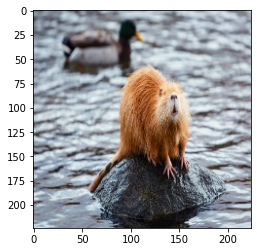

In [28]:
index = 38
print(train_img[index].shape)
print(train_label[index])
plt.imshow(train_img[index])

# **Data and Label shape**

In [29]:
print(train_img.shape)
print(train_label.shape)
print(val_img.shape)
print(val_label.shape)

(5734, 224, 224, 3)
(5734,)
(1434, 224, 224, 3)
(1434,)


# **Model Structure & Classifier**

In [30]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling=None,
)
for layer in base_model.layers:
    layer.trainable = False

top_model = models.Sequential()
top_model.add(layers.Flatten())
top_model.add(layers.Dense(4096, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(1024, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(n_classes, activation='softmax'))

wild_model = tf.keras.Model(inputs=base_model.input, outputs=top_model(base_model.output)) 

# **Compile & Fit**

In [31]:
wild_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

wild_model.fit(x=train_img,y=train_label, validation_data=val_dataset, shuffle=True,epochs=5)

Epoch 1/5
180/180 [==============================] - 71s 387ms/step - loss: 3.1698 - accuracy: 0.3655 - val_loss: 1.0394 - val_accuracy: 0.6116
Epoch 2/5
180/180 [==============================] - 58s 325ms/step - loss: 1.1004 - accuracy: 0.6261 - val_loss: 0.6856 - val_accuracy: 0.7643
Epoch 3/5
180/180 [==============================] - 58s 325ms/step - loss: 0.8625 - accuracy: 0.7075 - val_loss: 0.6369 - val_accuracy: 0.8075
Epoch 4/5
180/180 [==============================] - 58s 325ms/step - loss: 0.7171 - accuracy: 0.7557 - val_loss: 0.5825 - val_accuracy: 0.8389
Epoch 5/5
180/180 [==============================] - 59s 326ms/step - loss: 0.6771 - accuracy: 0.7782 - val_loss: 0.5108 - val_accuracy: 0.8445
